# Семинар 5. Классификация. Логистическая регрессия

In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    roc_curve,
    roc_auc_score,
    classification_report,
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

sns.set_theme(style="whitegrid", palette="Set1")

## Бинарная классификация

Мы по-прежнему говорим об обучении с учителем, то есть нам даны матрица объекты – признаки $ X $ и вектор целевых переменных $ \mathbf{y} $:

$$
X = 
\begin{bmatrix}
x_{11} & x_{12} & \dots & x_{1d} \\
x_{21} & x_{22} & \dots & x_{2d} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \dots & x_{nd} \\
\end{bmatrix},
\quad
\mathbf{y} = 
\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix}.
$$

В задаче _классификации_ целевая переменная принадлежит некоторому конечному множеству $ y_i \in \{0, 1, 2, \dots, K - 1\} $, где $ K $ — количество классов.

Сегодня мы поговорим о _бинарной классификации_. Для удобства рассмотрим $ y_i \in \{-1, 1\} $. В прошлый раз мы подробно обсуждали линейные модели вида

$$
\hat{y}_i = w_0 + w_1 x_{i1} + w_2 x_{i2} + \dots + w_d x_{id} = \langle \mathbf{x}_i,\mathbf{w} \rangle.
$$

и их применение в задаче _регрессии_. Давайте теперь модифицируем нашу модель и в качестве предсказания будем использовать знак скалярного произведения

$$
\hat{y}_i = \text{sign} \langle \mathbf{x}_i,\mathbf{w} \rangle.
$$

**Вопрос:** а как в таком случае можно интерпретировать модуль скалярного произведения?

Ранее мы также обсуждали, что на практике может быть полезно предсказывать вероятности классов. Очевидно, что скалярное произведение $ \langle \mathbf{x}_i,\mathbf{w} \rangle $ свойствами вероятности не обладает. Попробуем решить данную проблему при помощи функции $ f: \mathbb{R} \to [0, 1] $. Для этого отлично подойдет _сигмоида_

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

In [200]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

<Axes: >

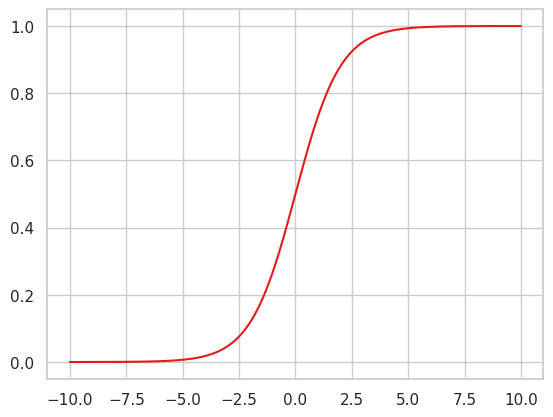

In [201]:
x = np.linspace(-10, 10, num=1_000)
y = sigmoid(x)

sns.lineplot(x=x, y=y)

## Логистическая регрессия

In [202]:
data = pd.read_csv("train.csv", index_col="PassengerId")
print(f"{data.shape = }")
data.head()

data.shape = (891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [203]:
data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [204]:
data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

<Axes: xlabel='Pclass', ylabel='Survived'>

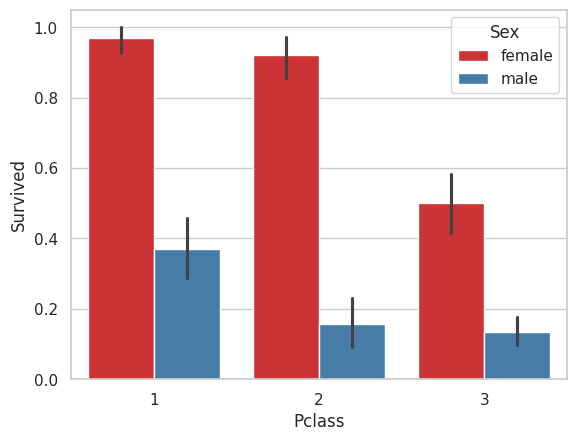

In [205]:
sns.barplot(data=data, x="Pclass", y="Survived", hue="Sex")

<Axes: xlabel='Age', ylabel='Count'>

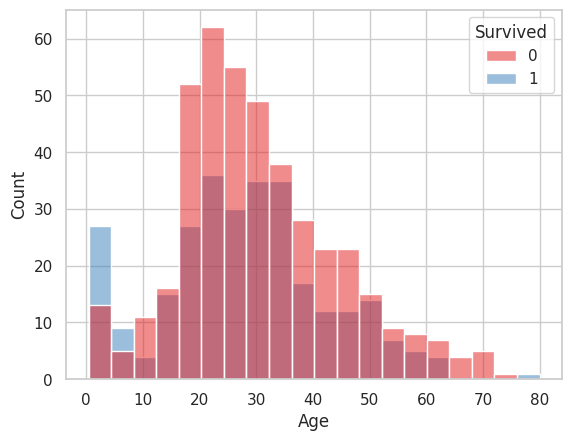

In [206]:
sns.histplot(data=data, x="Age", hue="Survived")

In [207]:
X, y = data.drop(columns=["Name", "Ticket", "Survived"]), data["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print(f"Размер обучающей выборки:\t{y_train.size}")
print(f"Размер тестовой выборки:\t{y_test.size}")

Размер обучающей выборки:	668
Размер тестовой выборки:	223


In [208]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,
487,1,female,35.00,1,0,90.0000,C93,S
239,2,male,19.00,0,0,10.5000,NaN,S
723,2,male,34.00,0,0,13.0000,NaN,S
185,3,female,4.00,0,2,22.0250,NaN,S
57,2,female,21.00,0,0,10.5000,NaN,S
...,...,...,...,...,...,...,...,...
548,2,male,NaN,0,0,13.8625,NaN,C
470,3,female,0.75,2,1,19.2583,NaN,C
737,3,female,48.00,1,3,34.3750,NaN,S


In [209]:
X_train.isna().sum()

Pclass        0
Sex           0
Age         131
SibSp         0
Parch         0
Fare          0
Cabin       522
Embarked      2
dtype: int64

In [210]:
processor = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), ("Pclass", "Sex", "Cabin", "Embarked")),
    (make_pipeline(SimpleImputer(), StandardScaler()), ("Age",)),
    (StandardScaler(), ("Fare",)),
)

X_train_processed = processor.fit_transform(X_train)
X_test_processed = processor.transform(X_test)

In [211]:
np.isnan(SimpleImputer().fit_transform(data[["Age"]])).sum()

np.int64(0)

In [212]:
clf = LogisticRegression().fit(X_train_processed, y_train)

probabilities = clf.predict_proba(X_test_processed)[:, 1]
print(f"Предсказанные вероятности:\t{probabilities[:5]}")

y_pred = clf.predict(X_test_processed)
print(f"Предсказанные метки:\t{y_pred[:5]}")

Предсказанные вероятности:	[0.07244871 0.73765448 0.18173336 0.66886287 0.13154456]
Предсказанные метки:	[0 1 0 1 0]


## Метрики качества классификации

In [213]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

$$ \text{Accuracy} = \frac{1}{n} \sum_{i = 1}^{n} [y_i = \hat{y}_i] = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}} $$

In [214]:
print(f"Accuracy:\t{(tp + tn) / (tp + tn + fp + fn):.3f}")
print(f"Accuracy:\t{accuracy_score(y_test, y_pred):.3f}")

Accuracy:	0.767
Accuracy:	0.767


$$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$

In [215]:
print(f"Precision:\t{tp / (tp + fp):.3f}")
print(f"Precision:\t{precision_score(y_test, y_pred):.3f}")

Precision:	0.689
Precision:	0.689


$$
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$

In [216]:
print(f"Recall:\t{tp / (tp + fn):.3f}")
print(f"Recall:\t{recall_score(y_test, y_pred):.3f}")

Recall:	0.721
Recall:	0.721


$$
F_1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Text(0.5, 1.0, 'Гармоническое среднее (F1)')

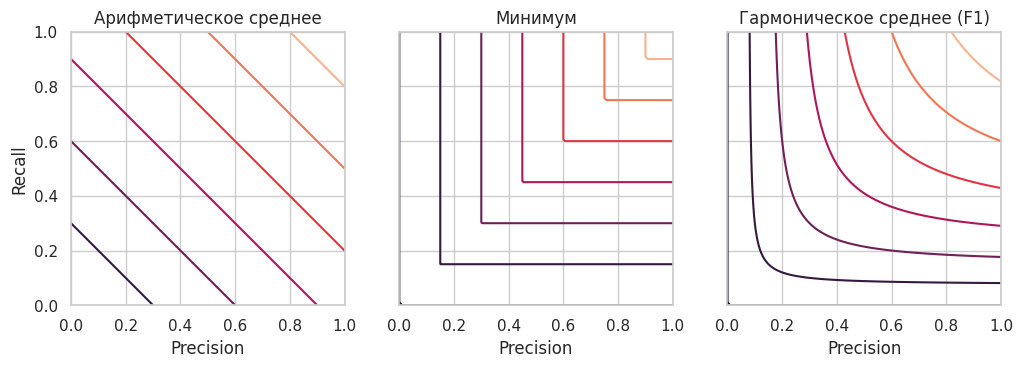

In [217]:
fig, axs = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(12, 4)

axs[0].set_ylabel("Recall")

for ax in axs:
    ax.set_aspect("equal")
    ax.set_xlabel("Precision")

p, r = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

axs[0].contour(p, r, (p + r) / 2)
axs[0].set_title("Арифметическое среднее")

axs[1].contour(p, r, np.minimum(p, r))
axs[1].set_title("Минимум")

axs[2].contour(p, r, 2 * (p * r) / (p + r + 1e-5))
axs[2].set_title("Гармоническое среднее (F1)")

In [218]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       137
           1       0.69      0.72      0.70        86

    accuracy                           0.77       223
   macro avg       0.75      0.76      0.76       223
weighted avg       0.77      0.77      0.77       223



$$ \text{TPR} = \frac{\text{TP}}{\text{TP} + \text{FN}}, \quad \text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}} $$

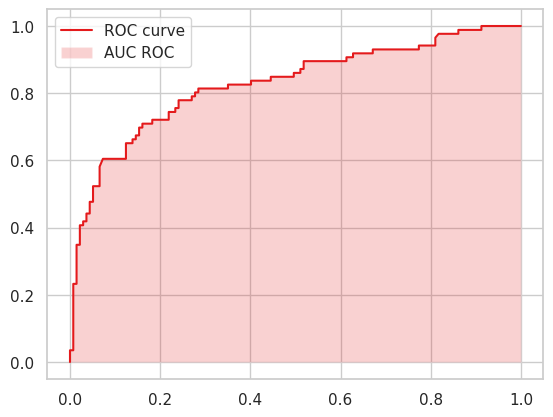

In [219]:
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

plt.plot(fpr, tpr, label="ROC curve")
plt.fill_between(fpr, tpr, alpha=0.2, label="AUC ROC")

plt.legend()

In [220]:
print(f"AUC ROC:\t{roc_auc_score(y_test, probabilities):.3f}")

AUC ROC:	0.827


## Линейная разделимость данных

(-4.0, 4.0)

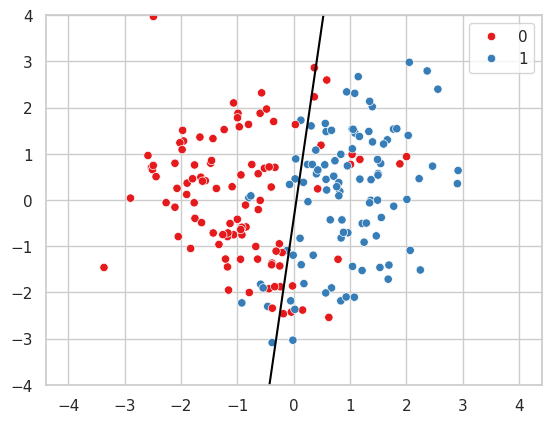

In [221]:
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, random_state=42)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)

clf = LogisticRegression()
clf.fit(X, y)

x1 = np.linspace(-4, 4)

# w0 + w1 x1 + w2 x2 = 0
w0 = clf.intercept_
w1, w2 = clf.coef_[0]

x2 = -(w0 + w1 * x1) / w2
sns.lineplot(x=x1, y=x2, color="black")
plt.ylim(-4, 4)

<Axes: >

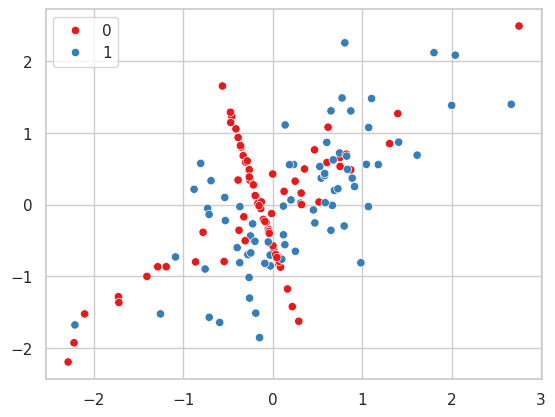

In [225]:
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, class_sep=0.2, random_state=451)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=451, stratify=y)

sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train)

In [226]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.64      0.62        25
           1       0.61      0.56      0.58        25

    accuracy                           0.60        50
   macro avg       0.60      0.60      0.60        50
weighted avg       0.60      0.60      0.60        50



In [229]:
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.80      0.71        25
           1       0.74      0.56      0.64        25

    accuracy                           0.68        50
   macro avg       0.69      0.68      0.68        50
weighted avg       0.69      0.68      0.68        50

